[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

notes:
 equal ventilation coefficients for both heavy and light isotopologues assumed (not given in the paper)
- definition of "b" in the paper (eq. 18) lacks multiplication by $\rho_\text{s}$ - units do not match, plot is OK - seems a typo in equation
- intriguing sign of the rhs in eq. (8) in the paper (gives drop mass increase for 0<S<1)

In [1]:
# TODO #1307 - x2 for Deuterium when using ratios?!
# TODO #1307 - move new formulae into physics 
# TODO #1307 - contour plot of dR/dt (from formulae) with zero isoline matching the paper fig?

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM')

In [3]:
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics.constants import si, PER_MILLE, T0
from matplotlib import pyplot
import numpy as np

VENTILATION_COEFFICIENT_RATIO = 1

FORMULAE = Formulae(isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994')
CONST = FORMULAE.constants

#### derivations:

- Maxwell-Mason equation (introducing $\rho_\text{s}=\frac{p_\text{vs}}{R_\text{v}T}$, approximated for $S_\text{eq}\approx 1$ and taking into account $\frac{l_\text{v}}{R_\text{v} T} \approx 20 \gg 1$):
$$
a\frac{da}{dt} 
= f \frac{
    S - S_\text{eq}
}{
    \rho_w \left(
        \frac{R_\text{v} T }{\Psi p_\text{vs}(T)} + 
        \frac{l_\text{v}}{K T} \left(\frac{l_\text{v}}{R_\text{v} T}-1\right)
    \right)
}
\approx \frac{f}{\rho_\text{w}} \frac{S - 1}{        \frac{1}{\Psi \rho_\text{s}} + 
        \frac{l^2_\text{v}}{K R_v T^2}
}
= \frac{f \Psi \rho_\text{s}}{\rho_\text{w}} \frac{S - 1}{        1 + 
        \frac{\Psi \rho_\text{s} l^2_\text{v}}{K R_v T^2}
}
$$
where $t$ is time, $a$ is drop radius, $f$ is ventilation factor, $\Psi$ is mass diffusion coefficient, $K$ thermal diffusion coefficient, $l_\text{v}$ is latent heat of condensation, $R_\text{v}$ gas constant for water vapour, $T$ temperature, $\rho_\text{w}$ density of water, $p_\text{vs}$ saturation vapour pressure.

In [4]:
print(f"lv/(Rv T) at the triple point: {CONST.l_tri / (CONST.Rv * CONST.T_tri):.3g}")

lv/(Rv T) at the triple point: 19.8


- expressed in terms of mass $m=\frac{4}{3}\pi a^3 \rho_\text{w}$:

$$\frac{dm}{dt} / [\text{surface}]
= \frac{d\left(\frac{4}{3}\pi a^3 \rho_\text{w}\right)}{dt} \frac{1}{4 \pi a}
= \rho_\text{w} a \frac{da}{dt}
$$

- introducing $b=\frac{l^2_\text{v} \Psi}{K R_\text{v}T^2}$ and approximating leads to eq. (16) in the paper:

$$
\frac{dm}{dt} 
\approx 4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b \rho_\text{s}}
$$

In [5]:
class Commons:  # pylint: disable=too-few-public-methods
    """ groups values used in both equations """
    def __init__(self, *, isotope, delta_v, temperature):
        self.vsmow_ratio = getattr(CONST, f'VSMOW_R_{isotope}')
        self.iso_ratio_v = FORMULAE.trivia.isotopic_delta_2_ratio(delta_v, self.vsmow_ratio)
        self.alpha_w = getattr(
            FORMULAE.isotope_equilibrium_fractionation_factors,
            f'alpha_l_{isotope}'
        )(temperature)
        self.diff_coef_ratio = getattr(CONST, f'D_light_H2O__over__D_{isotope}_enriched')

        missing_b_multiplier = FORMULAE.saturation_vapour_pressure.pvs_Celsius(temperature - T0) / temperature / CONST.Rv
        self.b = missing_b_multiplier * FORMULAE.latent_heat.lv(temperature)**2 * CONST.D0 / CONST.K0 / CONST.Rv / temperature**2
        
class NoFractionationSaturation:  # pylint: disable=too-few-public-methods
    """ embodies eqs. (22) an (23) from the paper """
    def __init__(self, cmn: Commons, *, liquid: bool = False, vapour: bool = False):
        assert liquid != vapour
        self.liquid = liquid
        self.cmn = cmn
        
    def __call__(self, iso_ratio_r):
        iso_ratio_x = iso_ratio_r if self.liquid else self.cmn.iso_ratio_v
        diff_rat = VENTILATION_COEFFICIENT_RATIO * self.cmn.diff_coef_ratio
        return (
            diff_rat * iso_ratio_x 
            - iso_ratio_r / self.cmn.alpha_w
        ) / (
            diff_rat * iso_ratio_x 
            - (1 + self.cmn.b) * self.cmn.iso_ratio_v
            + self.cmn.b * iso_ratio_r / self.cmn.alpha_w
        )

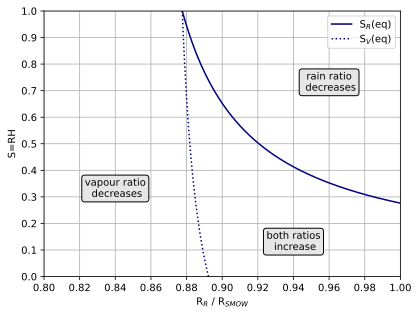

HTML(value="<a href='./fig_2.pdf' target='_blank'>./fig_2.pdf</a><br>")

In [6]:
commons = Commons(
    isotope='2H',
    delta_v= -200 * PER_MILLE,
    temperature= T0 + 10 * si.K,
)
x = np.linspace(commons.alpha_w * commons.iso_ratio_v / commons.vsmow_ratio, 1, 200)
y_eq_22 = NoFractionationSaturation(commons, liquid=True)(x * commons.vsmow_ratio)
y_eq_23 = NoFractionationSaturation(commons, vapour=True)(x * commons.vsmow_ratio)

pyplot.plot(x, y_eq_22, label='S$_R$(eq)', color='navy')
pyplot.plot(x, y_eq_23, label='S$_V$(eq)', color='navy', linestyle=':')

pyplot.xlim(.8, 1)
pyplot.xticks(np.linspace(.8, 1, 11))
pyplot.xlabel('R$_R$ / R$_{SMOW}$')

pyplot.ylim(0, 1)
pyplot.yticks(np.linspace(0, 1, 11))
pyplot.ylabel('S=RH')

pyplot.grid(visible=True, axis='both')
pyplot.legend()

kwargs = {'bbox': {'boxstyle': 'round', 'fc': '0.9'}, 'ha': 'center'}
pyplot.annotate(text="vapour ratio\n decreases", xy=(.84, .3), **kwargs)
pyplot.annotate(text="rain ratio\n decreases", xy=(.96, .7), **kwargs)
pyplot.annotate(text="both ratios\n increase", xy=(.94, .1), **kwargs)

show_plot('fig_2.pdf')